In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from scipy import optimize

In [2]:
def rbf_kernel(t,s,scale):

    return  np.exp((-(t-s)**2)/scale)

def fractional_kernel(t,s,alpha, eps=1e-3):

    return ((np.abs(t-s)+ eps))**(alpha-1)

In [3]:
t_vals = np.linspace(0,1,num=1000)

t, s = np.meshgrid(t_vals, t_vals)

# Nystrom

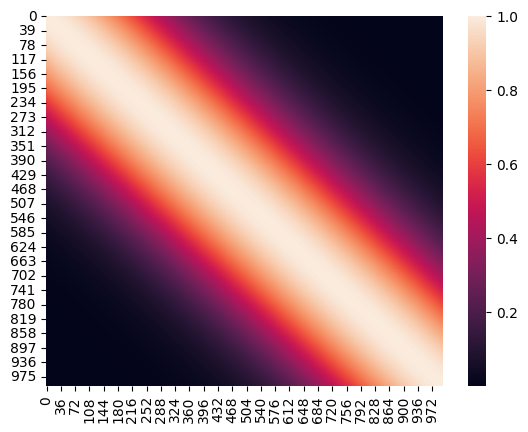

In [4]:
decomp_dim = 10
final_time = 1
num_timesteps = 1000
dt = final_time/num_timesteps

# kernel_mat = fractional_kernel(t, s, alpha=0.51)
kernel_mat = rbf_kernel(t, s, scale=0.1)

sns.heatmap(kernel_mat)
plt.show()

eigs = np.linalg.eig(kernel_mat)
eigen_values = np.real(eigs.eigenvalues[:decomp_dim])
eigen_vectors = np.real(eigs.eigenvectors[:decomp_dim])

eigen_vectors_diff = np.diff(eigen_vectors, axis=1)/dt

# Fourier Features

In [5]:
def sample_rff(x, kernel, lengthscale, coefficient, num_functions, num_features):

    # Dimension of data space
    x_dim = x.shape[-1]
    omega_shape = (num_functions, num_features, x_dim)
    
    # Handle each of three possible kernels separately
    if kernel == 'rbf':
        omega = np.random.normal(size=omega_shape)

    elif kernel == 'ou':
        omega =  np.random.standard_cauchy(size=omega_shape)

    elif kernel == 'cauchy':
        omega = np.random.laplace(size=omega_shape)

    # Scale omegas by lengthscale to adjust variance of the distributions
    omega = omega / lengthscale

    weights = np.random.normal(loc=0.,
                               scale=1.,
                               size=(num_functions, num_features))

    phi = np.random.uniform(low=0.,
                            high=(2 * np.pi),
                            size=(num_functions, num_features, 1))

    features = np.cos(np.einsum('sfd, nd -> sfn', omega, x) + phi)
    features = (2 / num_features) ** 0.5 * features * coefficient
    
    functions = np.einsum('sf, sfn -> sn', weights, features)
    
    return functions, features

In [6]:
decomp_dim = 10
final_time = 1
num_timesteps = 1000
dt = final_time/num_timesteps
functions, features = sample_rff(np.linspace(0,final_time, num_timesteps)[:, None], 
                                 "rbf",
                                  lengthscale=1,
                                  coefficient=1, 
                                  num_functions=decomp_dim,
                                  num_features=decomp_dim)

kernel_decomp = features[0].T
kernel_decomp_diff = np.diff(kernel_decomp, axis=0)/dt
decomp_weights = np.ones((num_timesteps, decomp_dim))

# Laplace

In [66]:
def rbf_kernel(t,s,scale):

    return  np.exp((-(t-s)**2)/scale)

def fractional_kernel(t,s,alpha, eps=1e-3):

    return ((np.abs(t-s)+ eps))**(alpha-1)

def sum_approx(t, s, c_g, n):

    list_obj = np.array([c_g[i]*np.exp(-c_g[n+i]*np.abs(t-s)) for i in range(n)])

    return np.sum(list_obj, axis=0)

def loss_function(c_g,
                  t,
                  s,
                  n,
                  kernel_function):

    mse = np.mean(np.abs(sum_approx(t, s, c_g, n) - kernel_function(t, s)))

    return mse

def find_best_c_g(t, s, n, kernel_function):

    c_g =  np.ones(2*n)

    min_func = partial(loss_function,
                       t=t,
                       s=s,
                       n=n,
                       kernel_function=kernel_function,
                       )

    return_vals = optimize.minimize(min_func, c_g)

    best_c_g = return_vals.x

    approx_func = partial(sum_approx, c_g=best_c_g, n=n)

    print("Converged: ", return_vals.success)

    return best_c_g, approx_func, return_vals

In [69]:
t_vals = np.linspace(0,1,num=1000)
t, s = np.meshgrid(t_vals, t_vals)

decomp_dim = 50

best_c_g, approx_func, return_vals =  find_best_c_g(t=t, 
                                                    s=s, 
                                                    n=decomp_dim, 
                                                    kernel_function=partial(rbf_kernel, scale=1))

Converged:  False


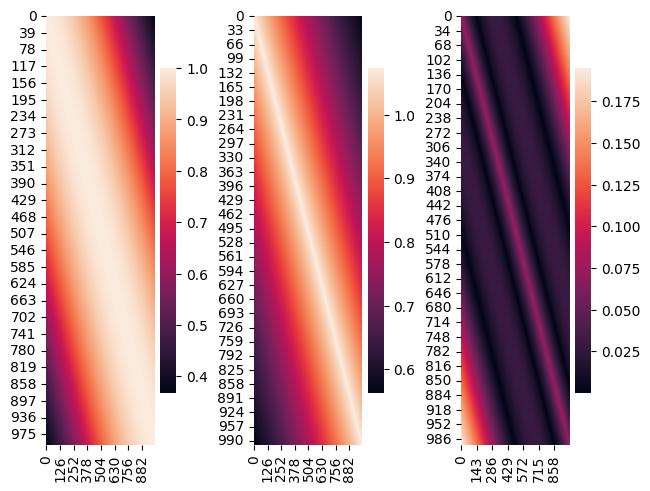

In [71]:
pred_mat = approx_func(t,s)
kernel_mat = rbf_kernel(t, s, scale=1)

fig, ax = plt.subplots(1,3, constrained_layout=True)
sns.heatmap(kernel_mat, ax=ax[0])
sns.heatmap(pred_mat, ax=ax[1])
sns.heatmap(np.abs(kernel_mat-pred_mat), ax=ax[2])
plt.show()

# Explicit Decomposition